In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [2]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

In [3]:
# Combine all cities into one dataframe and save to csv file
city_list = ['Atlanta', 'Charlotte', 'Cincinnati', 'Denver', 'Indianapolis', 'Providence', 'Tampa']
file_path = '../Data/Clean/combined/'
all_cities_df = pd.DataFrame()
for city in city_list:
    city_file_path = file_path + city + '_combined.csv'
    city_df = pd.read_csv(city_file_path)
    all_cities_df = pd.concat([all_cities_df, city_df])

all_cities_df.reset_index(drop=True, inplace=True)
all_cities_df.to_csv(f'{file_path}all_cities_combined.csv', index=False)

## Inspect the data

In [4]:
# Load the training data
all_cities_file_path = f'{file_path}all_cities_combined.csv'
train_full_df = pd.read_csv(all_cities_file_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [5]:
# Remove columns that are too predictive or misleading
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex', 'DATE', 'CityName']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

In [6]:
# Drop rows with missing values since we have all cities in one dataframe
# This leaves us with data from 2018 to 2024 for all cities
# train_full_df = train_full_df.dropna()
train_full_df.head()

,MeanSalePrice,SalesCount,TotalTransactionValue,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,SaleToList,NewConstructMeanSalePrice,...,PctSoldAboveList,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019
0,200954.0,6463.0,1.235943e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123
1,203419.0,6729.0,1.317605e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123
2,205746.0,7047.0,1.388670e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123
3,205553.0,7086.0,1.429205e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123
4,202855.0,6383.0,1.388101e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123


## Create an EdaToolbox object

In [7]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [8]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
People25PlusThousands_2019,float64,0.142857,4414.047790,7,0,0.0,"Index([4414.04779, 1777.64019, 1418.62244, 24..."
PctHighSchoolDiploma_2019,float64,0.142857,89.810682,7,0,0.0,"Index([89.810682, 91.950313, 93.921524, 91.688..."
PctBachelorsDegree_2019,float64,0.142857,41.859123,7,0,0.0,"Index([41.859123, 39.434102, 43.323481, 49.747..."
DaysToClose,float64,0.119048,32.000000,25,819,0.6,"Index([32.0, 33.0, 35.0, 37.0, 36.0, 38.0, 34...."
MarketTempIdx,float64,0.042125,53.000000,66,819,0.6,"Index([53.0, 52.0, 56.0, 67.0, 51.0, 55.0, 50...."


In [9]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.9

## First check the distribution of the target column and select an appropriate target column transformer

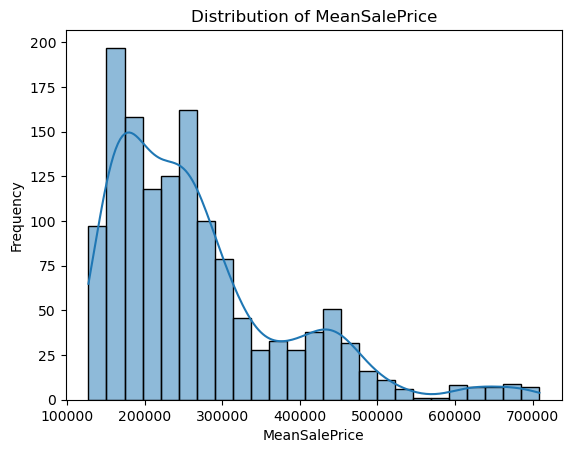

In [10]:
# Plot target column distribution
eda.plot_regression_target_column_distribution()

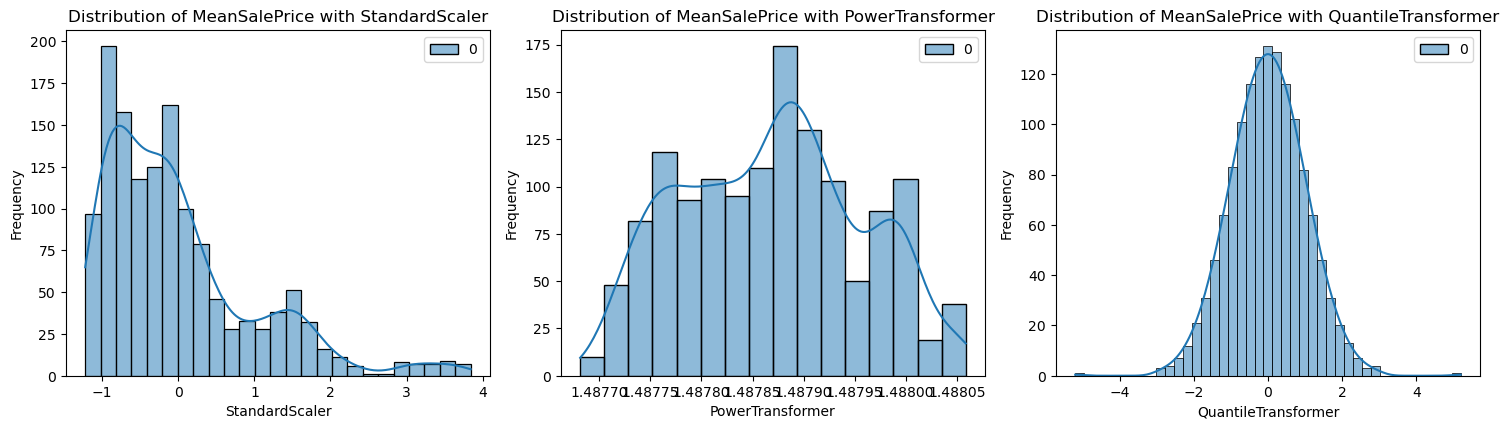

In [11]:
# It is not normally distributed. It has a strange tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}
eda.plot_regression_target_column_distribution_variations(target_transformation_dict)

In [12]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [13]:
# Create a KFold object for cross-validation
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [15]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.349140,0.348842,0.999761,0.922068,0.355779,0.367631,0.348805,0.107837
PowerTransformer,0.000039,0.000039,0.000088,0.000088,0.000066,0.000066,0.000039,0.000009
QuantileTransformer,0.484765,0.484507,1.013425,0.979817,0.761519,0.815346,0.484320,0.167189


## Set the target and feature column tranformers

* Use the PowerTransformer for the target column
* Use the basic ordinal feature transformer

In [16]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = PowerTransformer(standardize=False)
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Perform Feature analysis

In [17]:
# Frist check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  0.81)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__TotalTransactionValue,0.598135,0.000128,7.296549e-18,5.734144,0.015749,0.440737,1.054749
numerical__PctSoldBelowList,0.239475,0.000012,9.009722e-01,58.059966,0.381402,0.119431,0.740320
numerical__ListingPriceCutAmt,0.324136,0.000009,5.646518e-01,7.900132,0.338229,0.046458,0.708831
numerical__SaleToList,0.227868,0.000007,5.983078e-01,14.922203,0.379272,0.094044,0.701190
numerical__SalesCount,0.196533,0.000042,6.666773e-03,10.659361,0.058288,0.436635,0.691497


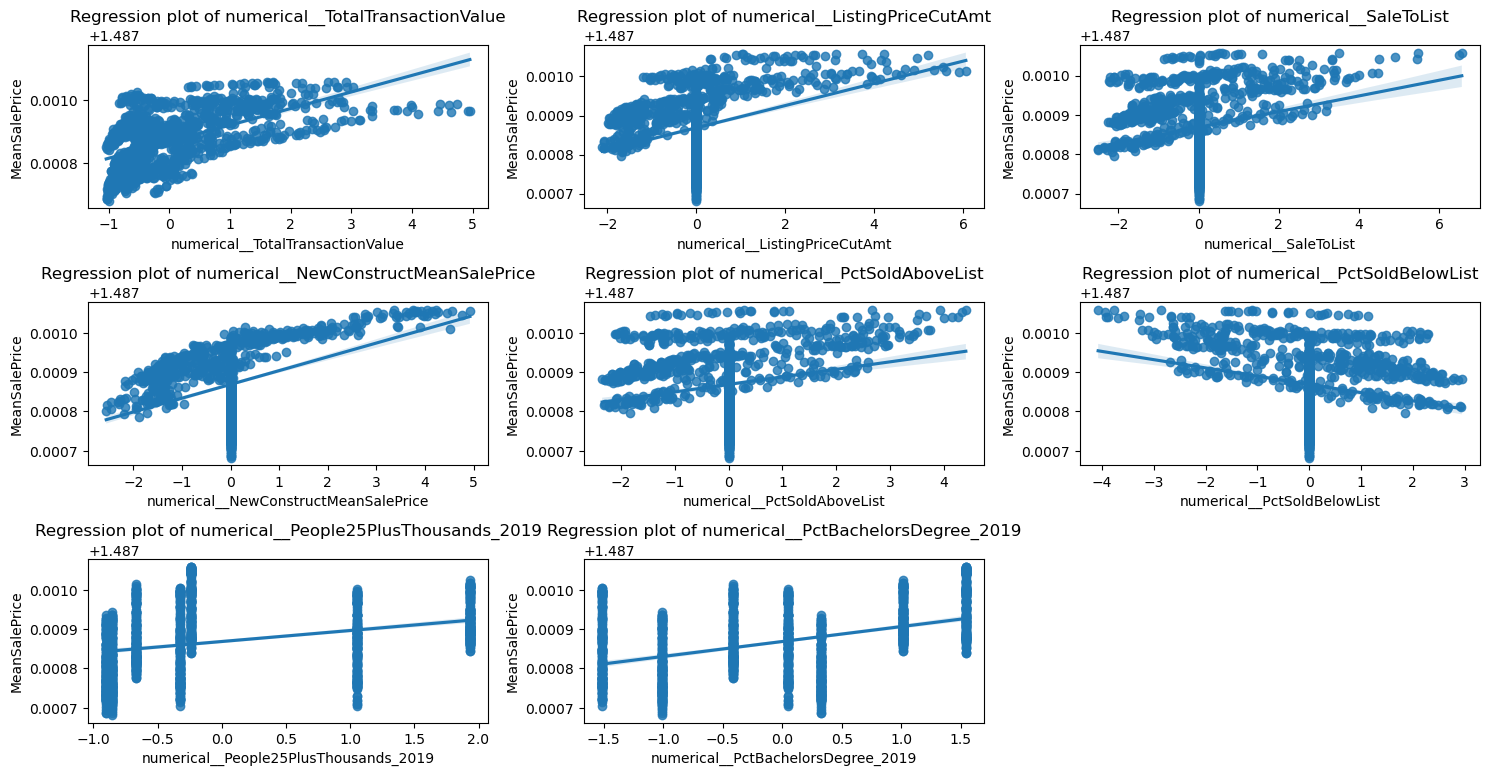

In [18]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.2)

## Perform unsupervised feature selection

Optimal number of features: 5


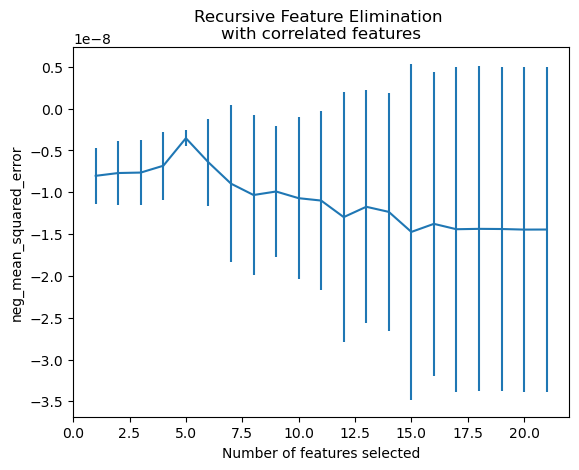

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-8.038195e-09,3.377820e-09,-5.465490e-09,-8.333845e-09,-1.380957e-08,-3.953494e-09,-8.628574e-09,True,1,SalesCount
1,-7.704046e-09,3.846235e-09,-5.433235e-09,-8.331328e-09,-1.379560e-08,-2.207566e-09,-8.752504e-09,True,1,TotalTransactionValue
2,-7.649296e-09,3.834815e-09,-5.410153e-09,-8.269455e-09,-1.372970e-08,-2.162270e-09,-8.674902e-09,False,16,MarketTempIdx
3,-6.830416e-09,4.057725e-09,-1.399272e-08,-3.805635e-09,-6.621972e-09,-2.209229e-09,-7.522527e-09,False,2,DaysToClose
4,-3.538883e-09,9.382078e-10,-3.710126e-09,-3.813749e-09,-4.167782e-09,-1.712394e-09,-4.290361e-09,False,9,DaysOnZillow


In [19]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [20]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['SalesCount' 'TotalTransactionValue' 'MORTGAGE15US' 'MORTGAGE30US'
 'RATE_DIFFERENCE']


Optimal number of features: 2


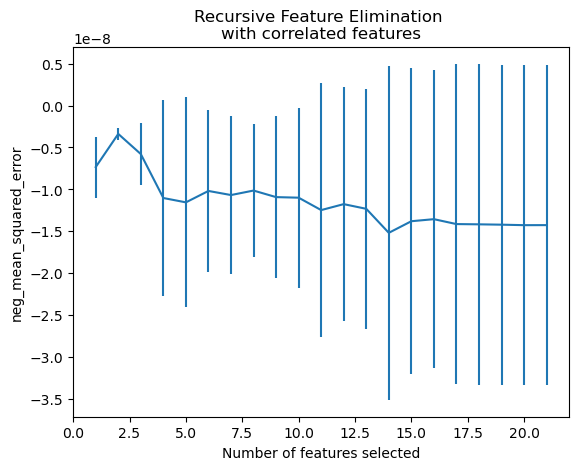

In [21]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=5))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [22]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['SalesCount' 'TotalTransactionValue']


In [23]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 7 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=7)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 1.0
Selected 7 features by forward sequential featureselection in 1.714 seconds
SFS Ridge Selected Features: ['TotalTransactionValue', 'NewConstructMeanSalePrice', 'NewConstructSalesCount', 'PctListingsPriceCut', 'MORTGAGE30US', 'NUM_JOBS', 'PctBachelorsDegree_2019']


In [24]:
# # Remove the last feature
# sfs_ridge_selected_features = sfs_ridge_selected_features[:-1]
# sfs_ridge_selected_features

In [25]:
# Update EDA object with selected features from SFS
eda.selected_feature_list = sfs_ridge_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(0, [])

## Perform final EDA with selected features and ordinal columns

In [26]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.9)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=['TotalTransactionValue',
                                                                                                     'NewConstructMeanSalePrice',
                                                                                                     'NewConstructSalesCount',
                                                                                                     'PctListingsPriceCut',
                                                                                                     'MORTGAGE30US',
                                                                                                     'NUM_JOBS',
                                                                                                     'PctBachelorsDegree_2019'])),
                                                 (...
       'DaysOnZillow', 'ListingPriceCutAmt', 'ListingPriceCutPct',
       'SaleToList', 'NewConstructMeanSalePrice', 'NewConstructSalesCount',
       'PctListingsPriceCut', 'PctSoldAboveList', 'PctSoldBelowList',
       'MORTGAGE15US', 'MORTGAGE30US', 'RATE_DIFFERENCE', 'NUM_JOBS',
       'GROWTH_PCT', 'People25PlusThousands_2019', 'PctHighSchoolDiploma_2019',
       'PctBachelorsDegree_2019'],
      dtype='object'))])

In [27]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  0.74)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__TotalTransactionValue,0.598135,0.000099,8.089160e-20,2.863423,0.580215,0.110665,1.289114
numerical__NewConstructMeanSalePrice,0.400002,0.000005,2.342104e-03,1.600861,0.012940,0.644300,1.057247
numerical__PctBachelorsDegree_2019,0.433083,0.000025,7.823193e-03,1.216358,0.053669,0.368183,0.854960
numerical__NUM_JOBS,0.133236,0.000051,2.439150e-06,2.630165,0.598700,0.027877,0.759865
numerical__NewConstructSalesCount,0.051372,0.000017,3.633590e-02,1.765329,0.540793,0.154892,0.747075


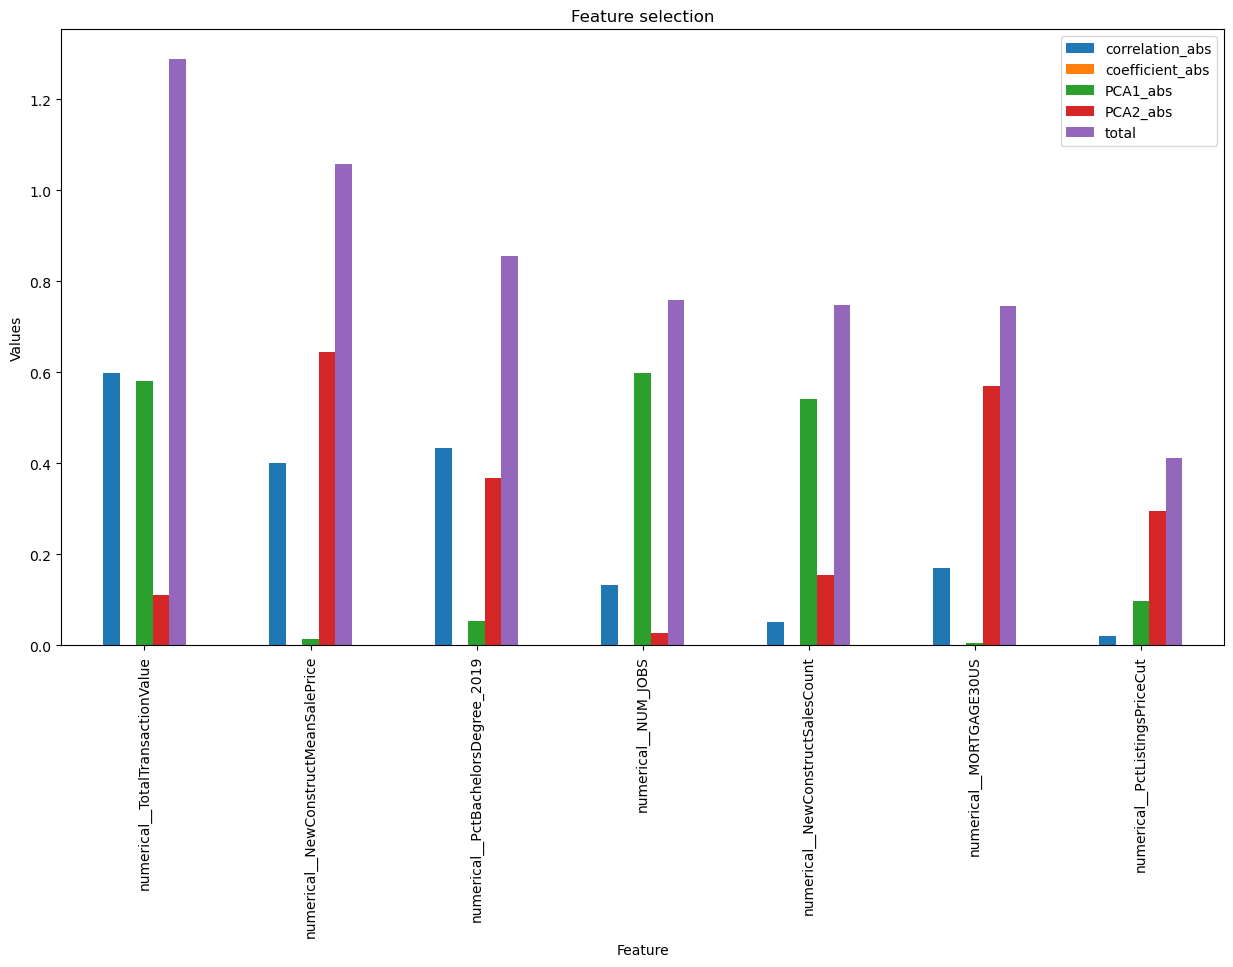

In [28]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [33]:
# Reload the data just to be safe
train_full_df = pd.read_csv(all_cities_file_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [34]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [35]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25
Number scaled X cols: 7


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
HistGradientBoost,0.998525,1.390585e-10,0.981245,0.980749,0.74105,0.019088,0.477895,"[1.4879279805400834, 1.4878816894857922, 1.487..."
Linear Regression,0.736325,1.835222e-09,0.752478,0.745939,0.74105,0.019088,0.015458,"[1.487890899907379, 1.4878303380701, 1.4878007..."
LassoCV,0.736313,1.838092e-09,0.752091,0.745542,0.74105,0.019088,0.092459,"[1.4878908127866777, 1.4878302363544842, 1.487..."
ElasticNetCV,0.736313,1.838092e-09,0.752091,0.745542,0.74105,0.019088,0.086677,"[1.487890812779722, 1.4878302363457911, 1.4878..."
Ridge Regression,0.736319,1.838184e-09,0.752078,0.745529,0.74105,0.019088,0.014481,"[1.4878907984410092, 1.4878302114118056, 1.487..."
RidgeCV,0.736319,1.838184e-09,0.752078,0.745529,0.74105,0.019088,0.012000,"[1.4878907984410092, 1.4878302114118058, 1.487..."


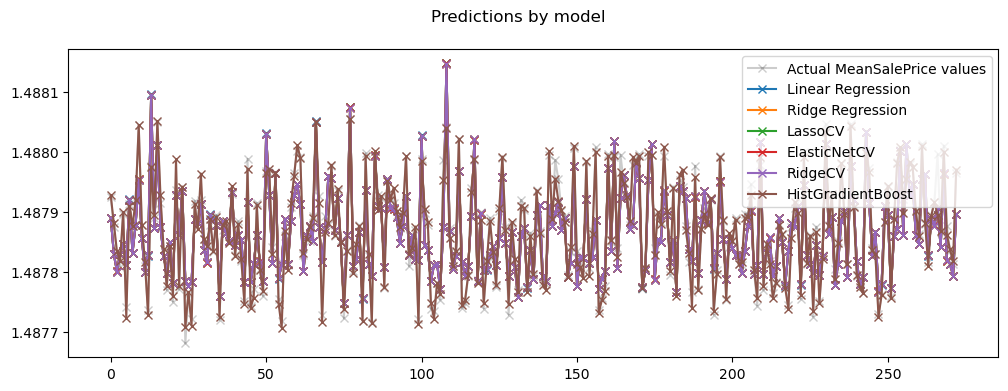

In [36]:
reg.plot_model_evaluations()

In [37]:
# Get the best model
reg.best_model_name

'HistGradientBoost'

## Now use the best model to predict on the test data

In [38]:
# Load test data for a specific city
atlanta_file_path = '../Data/Clean/combined/Atlanta_combined.csv'
test_full_df = pd.read_csv(atlanta_file_path)

# Drop target column
atlanta_actual_values = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col])
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


Number scaled X cols: 7


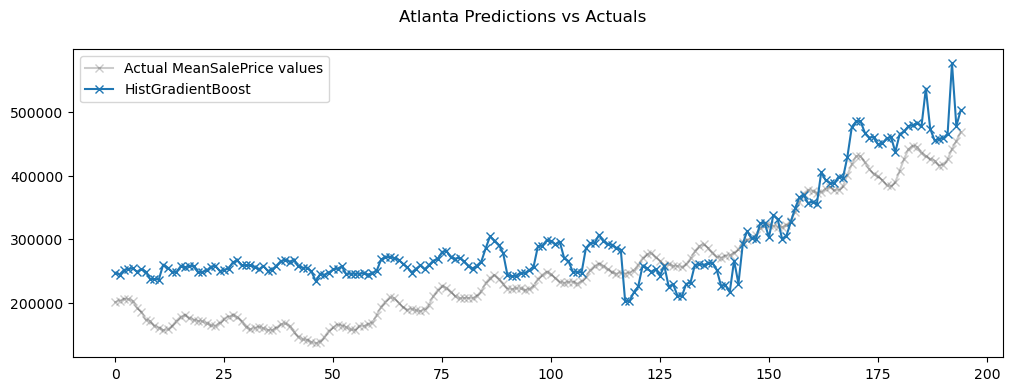

In [39]:
# Make predictions with HistGradientBoost
reg.best_model = model_dict['HistGradientBoost']
hgb_predictions = reg.predict(test_full_df)

# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(hgb_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

Number scaled X cols: 7


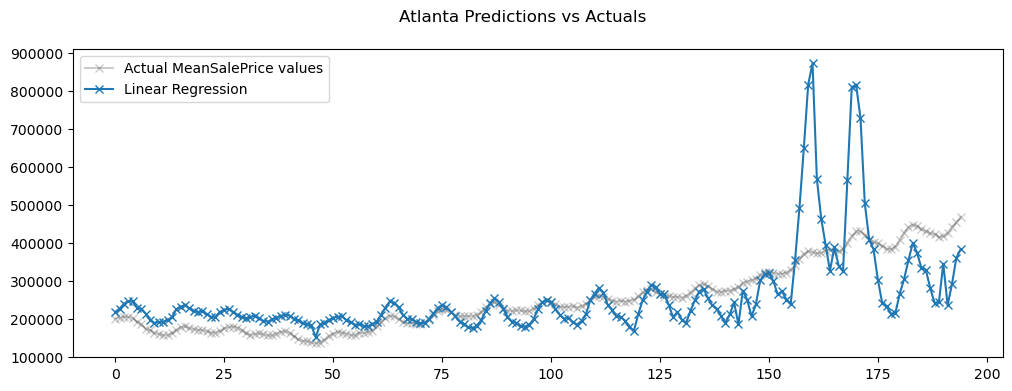

In [41]:
# Try Linear Regression model
reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)

# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="Linear Regression")
_ = ax.legend()

Number scaled X cols: 7


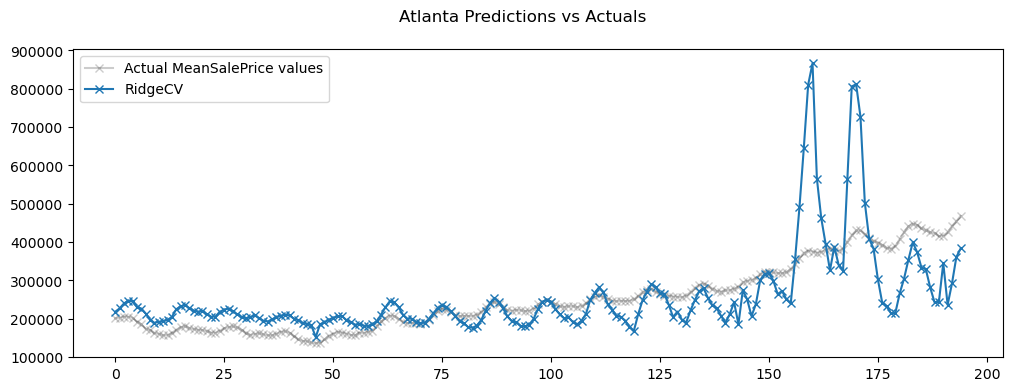

In [42]:
# Try RidgeCV model
reg.best_model = model_dict['RidgeCV']
lr_predictions = reg.predict(test_full_df)

# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="RidgeCV")
_ = ax.legend()